In [ ]:
import numpy as np
from numpy.typing import NDArray
from typing import Tuple, Optional, Sequence


def _create_hex_grid(
    data_samples: NDArray[np.float64],
    dimension_range: Optional[Sequence[Tuple[float, float]]] = None,
    hexagon_width: float = 1.0,
) -> Tuple[
    NDArray[np.float64],  # bin_centers
    Tuple[int, ...],  # centers_shape
    float,  # hex_radius
    float,  # hex_orientation
    float,  # min_x
    float,  # min_y
    float,  # hexagon_width
]:
    """Creates a hexagonal grid based on data_samples data.
    The grid is defined by hexagons of a specified width.
    The hexagons are arranged in a staggered pattern.
    The grid is centered around the provided data_samples data.
    The hexagons are oriented with one vertex pointing up.

    Parameters
    ----------
    data_samples : NDArray[np.float64], shape (n_time, 2)
        data_samples data. Used to determine grid extent if `dimension_range`
        is None. NaNs are ignored.
    dimension_range : Optional[Sequence[Tuple[float, float]]], optional
        Explicit grid boundaries [(min_dim1, max_dim1), ...]. If None,
        boundaries are derived from `data_samples`. Defaults to None.
    hexagon_width : float, optional
        The width of the hexagons in the grid. Defaults to 1.0.
        Must be positive.

    Returns
    -------
    bin_centers : NDArray[np.float64], shape (n_total_bins, 2)
        Center coordinates of each hexagon in the flattened grid.
    centers_shape : Tuple[int, ...]
        Shape of the grid (number of hexagons in each dimension).
    hex_radius : float
        The radius of the hexagons (distance from center to vertex).
    hex_orientation : float
        The orientation of the hexagons (0.0 for point-up).

    Raises
    ------
    ValueError
        If `data_samples` is empty and no `dimension_range` is provided.
        If `data_samples` is not a 2D array with shape (n_samples, 2).
        If `hexagon_width` is not positive.
    """
    if hexagon_width <= 0:
        raise ValueError("hexagon_width must be positive.")

    # Orientation of hexagons (0.0 for point-up)
    hex_orientation = 0.0

    # Filter out NaN values from data_samples
    if data_samples is not None:
        valid_data_mask = ~np.isnan(data_samples).any(axis=1)
        data_samples = data_samples[valid_data_mask]
    else:
        data_samples = np.empty((0, 2))

    # Step 1: Calculate the bounding box
    if dimension_range is not None:
        min_x_user, max_x_user = dimension_range[0]
        min_y_user, max_y_user = dimension_range[1]

        # Ensure min <= max for user-provided ranges and cast to float
        min_x = min(float(min_x_user), float(max_x_user))
        max_x = max(float(min_x_user), float(max_x_user))
        min_y = min(float(min_y_user), float(max_y_user))
        max_y = max(float(min_y_user), float(max_y_user))
    else:
        if (
            not isinstance(data_samples, np.ndarray)
            or data_samples.ndim != 2
            or data_samples.shape[1] != 2
        ):
            raise ValueError(
                "data_samples must be a 2D NumPy array with shape (n_samples, 2)."
            )
        if data_samples.shape[0] == 0:
            raise ValueError(
                "data_samples is empty and no dimension_range is provided. "
                "Cannot determine grid extent."
            )
        min_vals = np.min(data_samples, axis=0)
        max_vals = np.max(data_samples, axis=0)
        min_x, min_y = float(min_vals[0]), float(min_vals[1])
        max_x, max_y = float(max_vals[0]), float(max_vals[1])

    grid_vertical_step = (np.sqrt(3.0) / 2.0) * hexagon_width

    range_x = max_x - min_x
    range_y = max_y - min_y

    # radius = side length of hexagon (center to vertex)
    hex_radius = hexagon_width / np.sqrt(3)

    n_hex_x = int(np.ceil(range_x / hexagon_width)) + 1
    n_hex_y = int(np.ceil(range_y / grid_vertical_step)) + 1

    # Create grid of base indices
    coord_x, coord_y = np.meshgrid(
        np.arange(n_hex_x), np.arange(n_hex_y), indexing="xy"
    )

    # Cast to float for calculations
    coord_x = coord_x.astype(float)
    coord_y = coord_y.astype(float)

    # Shift odd rows by half a hexagon width
    coord_x[1::2, :] += 0.5

    # Scale to real-world coordinates relative to a (0,0) grid origin
    coord_x = coord_x * hexagon_width
    coord_y = coord_y * grid_vertical_step

    # Shift the entire grid so its effective origin aligns with (min_x, min_y)
    coord_x += min_x
    coord_y += min_y

    bin_centers = np.column_stack((coord_x.flatten(), coord_y.flatten()))
    centers_shape: Tuple[int, int] = (n_hex_y, n_hex_x)

    return (
        bin_centers,
        centers_shape,
        hex_radius,
        hex_orientation,
        min_x,
        min_y,
        hexagon_width,
    )


def _cartesian_to_fractional_cube(
    points_x: NDArray[np.float64],
    points_y: NDArray[np.float64],
    hex_radius: float,
) -> Tuple[NDArray[np.float64], NDArray[np.float64], NDArray[np.float64]]:
    """Converts Cartesian coordinates to fractional cube coordinates for pointy-top hexagons.

    Parameters
    ----------
    points_x : NDArray[np.float64], shape (n_points,)
        X-coordinates of the points, relative to the grid's effective origin.
    points_y : NDArray[np.float64], shape (n_points,)
        Y-coordinates of the points, relative to the grid's effective origin.
    hex_radius : float
        Radius of the hexagons (center to vertex).

    Returns
    -------
    Tuple[NDArray[np.float64], NDArray[np.float64], NDArray[np.float64]]
        Fractional cube coordinates (q_frac, r_frac, s_frac), each shape (n_points,).
        q + r + s = 0.
        column (q) and row (r) coordinates are returned, with s calculated as s = -q - r.
    """
    if hex_radius == 0:  # Avoid division by zero
        # If hex_radius is zero, implies a degenerate grid.
        # Return zeros or handle as an error appropriately.
        # For now, returning zeros, assuming points effectively map to a single point.
        zero_coords = np.zeros_like(points_x)
        return zero_coords, zero_coords, zero_coords

    q_frac = (np.sqrt(3.0) / 3.0 * points_x - 1.0 / 3.0 * points_y) / hex_radius
    r_frac = (2.0 / 3.0 * points_y) / hex_radius
    s_frac = -q_frac - r_frac
    return q_frac, r_frac, s_frac


def _round_fractional_cube_to_integer_axial(
    q_frac: NDArray[np.float64],
    r_frac: NDArray[np.float64],
    s_frac: NDArray[np.float64],
) -> Tuple[NDArray[np.int_], NDArray[np.int_]]:
    """Rounds fractional cube coordinates to integer axial coordinates (q, r).

    This process ensures that the sum of integer cube coordinates is zero by
    adjusting the coordinate with the largest fractional difference.

    Parameters
    ----------
    q_frac : NDArray[np.float64], shape (n_points,)
        Fractional q cube coordinates.
    r_frac : NDArray[np.float64], shape (n_points,)
        Fractional r cube coordinates.
    s_frac : NDArray[np.float64], shape (n_points,)
        Fractional s cube coordinates. (s = -q -r)

    Returns
    -------
    Tuple[NDArray[np.int_], NDArray[np.int_]]
        Integer axial coordinates (q_axial, r_axial), each shape (n_points,).
    """
    # Initial rounding to nearest integer
    q_round_f: NDArray[np.float64] = np.round(q_frac)
    r_round_f: NDArray[np.float64] = np.round(r_frac)
    s_round_f: NDArray[np.float64] = np.round(
        s_frac
    )  # s_round = np.round(-q_frac - r_frac)

    # Differences from original fractional values
    q_diff: NDArray[np.float64] = np.abs(q_round_f - q_frac)
    r_diff: NDArray[np.float64] = np.abs(r_round_f - r_frac)
    s_diff: NDArray[np.float64] = np.abs(s_round_f - s_frac)

    # Initialize axial coordinates with the basic rounded values
    q_axial: NDArray[np.int_] = q_round_f.astype(int)
    r_axial: NDArray[np.int_] = r_round_f.astype(int)
    # s_axial for sum check, not directly returned for offset conversion
    # s_axial: NDArray[np.int_] = s_round_f.astype(np.int_)

    # Correct coordinates to ensure q_axial + r_axial + s_axial = 0
    # Condition where q_diff is strictly the largest
    cond1: NDArray[np.bool_] = (q_diff > r_diff) & (q_diff > s_diff)
    q_axial[cond1] = (-r_round_f[cond1] - s_round_f[cond1]).astype(int)
    # r_axial[cond1] remains r_round_f[cond1]

    # Condition where r_diff is strictly the largest (and q_diff was not)
    cond2: NDArray[np.bool_] = (~cond1) & (r_diff > s_diff)
    r_axial[cond2] = (-q_round_f[cond2] - s_round_f[cond2]).astype(int)
    # q_axial[cond2] remains q_round_f[cond2]

    # Condition where s_diff is largest (or ties put it here), and others were not
    # In this case, s_axial would be adjusted:
    # s_axial[cond3] = (-q_round_f[cond3] - r_round_f[cond3]).astype(np.int_)
    # q_axial and r_axial remain as their initially rounded values, which is correct.
    # No explicit action needed for q_axial, r_axial under cond3 as they are already set.

    return q_axial, r_axial


def _axial_to_offset_bin_indices(
    q_axial: NDArray[np.int_],
    r_axial: NDArray[np.int_],
    n_hex_x: int,
    n_hex_y: int,
) -> NDArray[np.int_]:
    """Converts integer axial coordinates (q, r) to 1D bin indices for an "odd-r" offset grid.

    Parameters
    ----------
    q_axial : NDArray[np.int_], shape (n_points,)
        Integer q axial coordinates.
    r_axial : NDArray[np.int_], shape (n_points,)
        Integer r axial coordinates.
    n_hex_x : int
        Number of hexagons in the x-direction of the grid.
    n_hex_y : int
        Number of hexagons in the y-direction of the grid.

    Returns
    -------
    NDArray[np.int_], shape (n_points,)
        1D bin indices. Points outside the grid are assigned an index of -1.
    """
    # Convert axial to "odd-r" offset coordinates
    # col = q + (r - (r & 1)) / 2
    # row = r
    # (r_axial & 1) is 1 if r_axial is odd, 0 if even. Works for negative r_axial.
    grid_col: NDArray[np.int_] = q_axial + (r_axial - (r_axial & 1)) // 2
    grid_row: NDArray[np.int_] = r_axial

    # Calculate 1D bin index (row-major flattening)
    # bin_idx = row * num_cols + col
    bin_idx: NDArray[np.int_] = grid_row * n_hex_x + grid_col

    # Mark out-of-bounds indices as -1
    valid_mask: NDArray[np.bool_] = (
        (grid_col >= 0) & (grid_col < n_hex_x) & (grid_row >= 0) & (grid_row < n_hex_y)
    )

    final_bin_idx: NDArray[np.int_] = np.full_like(bin_idx, -1, dtype=np.int_)
    final_bin_idx[valid_mask] = bin_idx[valid_mask]

    return final_bin_idx


def assign_points_to_hexagons(
    data_points: NDArray[np.float64],
    grid_offset_x,
    grid_offset_y,
    hex_radius,
    centers_shape,
) -> NDArray[np.int_]:
    """Assigns data points to hexagon bins in a pre-defined grid.

    Parameters
    ----------
    data_points : NDArray[np.float64], shape (n_points, 2)
        The (x, y) coordinates of the points to assign to bins.
    grid_params : HexGridParameters
        A dictionary containing the parameters of the hexagonal grid,
        typically obtained from `_create_hex_grid`.

    Returns
    -------
    NDArray[np.int_], shape (n_points,)
        The 1D bin index for each data point. Points falling outside
        the defined grid area are assigned an index of -1. NaN input points
        also result in an index of -1.
    """
    n_points = data_points.shape[0]
    if n_points == 0:
        return np.array([], dtype=np.int_)

    output_indices: NDArray[np.int_] = np.full(n_points, -1, dtype=np.int_)

    # Identify valid (non-NaN) points
    valid_mask: NDArray[np.bool_] = ~np.isnan(data_points).any(axis=1)
    if not np.any(valid_mask):
        return output_indices  # All points are NaN or empty after all

    valid_points: NDArray[np.float64] = data_points[valid_mask]

    # Adjust points relative to the grid's effective origin
    # (grid_offset_x, grid_offset_y) is the center of hex (0,0) in grid indices
    adj_points_x: NDArray[np.float64] = valid_points[:, 0] - grid_offset_x
    adj_points_y: NDArray[np.float64] = valid_points[:, 1] - grid_offset_y

    # Convert Cartesian to fractional cube coordinates
    q_frac, r_frac, s_frac = _cartesian_to_fractional_cube(
        adj_points_x, adj_points_y, hex_radius
    )

    # Round fractional cube coordinates to integer axial coordinates
    q_axial, r_axial = _round_fractional_cube_to_integer_axial(q_frac, r_frac, s_frac)

    # Convert axial coordinates to 1D bin indices
    n_hex_y, n_hex_x = centers_shape
    bin_indices_for_valid_points = _axial_to_offset_bin_indices(
        q_axial, r_axial, n_hex_x, n_hex_y
    )

    output_indices[valid_mask] = bin_indices_for_valid_points

    return output_indices

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


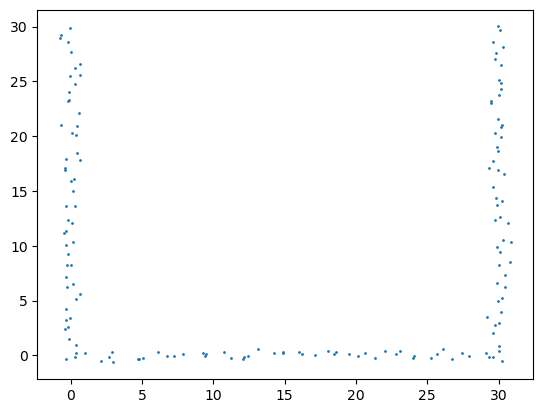

In [2]:
from scipy.stats import multivariate_normal
import numpy as np

import matplotlib.pyplot as plt
from track_linearization import make_track_graph

x = np.linspace(0, 30)

position = np.concatenate(
    (
        np.stack((np.zeros_like(x), x[::-1]), axis=1),
        np.stack((x, np.zeros_like(x)), axis=1),
        np.stack((np.ones_like(x) * 30, x), axis=1),
    )
)
position += multivariate_normal(mean=0, cov=0.1).rvs(position.shape)

node_positions = [
    (0, 0),  # xy position of node 0
    (30, 0),  # xy position of node 1
    (30, 30),  # xy position of node 2
    (0, 30),  # xy position of node 3
]

edges = [
    (0, 1),  # connects node 0 and node 1
    (0, 3),  # connects node 0 and node 3
    (1, 2),  # connects node 1 and node 2
]

track_graph = make_track_graph(node_positions, edges)

plt.scatter(position[:, 0], position[:, 1], s=1, label="observations")

In [ ]:
(
    bin_centers,
    centers_shape,
    hex_radius,
    hex_orientation,
    min_x,
    min_y,
    hexagon_width,
) = _create_hex_grid(data_samples=position, dimension_range=None, hexagon_width=1.0)

bin_ind = assign_points_to_hexagons(
    data_points=position,
    grid_offset_x=min_x,
    grid_offset_y=min_y,
    hex_radius=hex_radius,
    centers_shape=centers_shape,
)

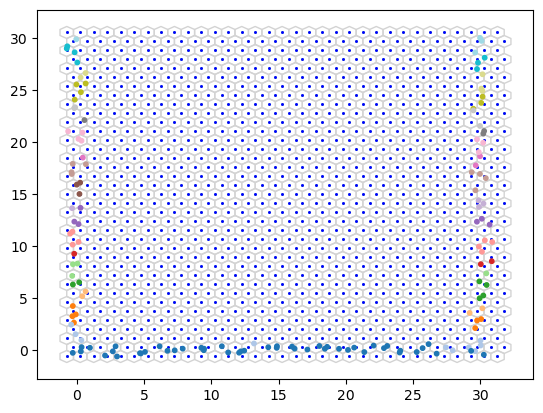

In [17]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots()
ax.scatter(bin_centers[:, 0], bin_centers[:, 1], s=1, label="hexagonal grid")
patches = [
    mpatches.RegularPolygon(
        (x, y), numVertices=6, radius=hex_radius, orientation=hex_orientation
    )
    for x, y in bin_centers
]


collection = PatchCollection(
    patches, edgecolor="lightgrey", facecolor="none", linewidths=1
)
ax.add_collection(collection)
ax.plot(
    bin_centers[:, 0],
    bin_centers[:, 1],
    marker="o",
    markersize=1,
    color="blue",
    linestyle="None",
    label="midpoint",
)
ax.scatter(
    position[:, 0],
    position[:, 1],
    zorder=10,
    s=10,
    label="observations",
    c=bin_ind,
    cmap="tab20",
)

In [24]:
from typing import Dict, List, Optional, Sequence, Set, Tuple

import networkx as nx
import numpy as np
from numpy.typing import NDArray


def _create_hex_grid(
    data_samples: NDArray[np.float64],
    dimension_range: Optional[Sequence[Tuple[float, float]]] = None,
    hexagon_width: float = 1.0,
) -> Tuple[
    NDArray[np.float64],  # bin_centers
    Tuple[int, ...],  # centers_shape
    float,  # hex_radius
    float,  # hex_orientation
    float,  # min_x
    float,  # min_y
    float,  # hexagon_width
]:
    """Creates a hexagonal grid based on data_samples data.
    The grid is defined by hexagons of a specified width.
    The hexagons are arranged in a staggered pattern.
    The grid is centered around the provided data_samples data.
    The hexagons are oriented with one vertex pointing up.

    Parameters
    ----------
    data_samples : NDArray[np.float64], shape (n_time, 2)
        data_samples data. Used to determine grid extent if `dimension_range`
        is None. NaNs are ignored.
    dimension_range : Optional[Sequence[Tuple[float, float]]], optional
        Explicit grid boundaries [(min_dim1, max_dim1), ...]. If None,
        boundaries are derived from `data_samples`. Defaults to None.
    hexagon_width : float, optional
        The width of the hexagons in the grid. Defaults to 1.0.
        Must be positive.

    Returns
    -------
    bin_centers : NDArray[np.float64], shape (n_total_bins, 2)
        Center coordinates of each hexagon in the flattened grid.
    centers_shape : Tuple[int, ...]
        Shape of the grid (number of hexagons in each dimension).
    hex_radius : float
        The radius of the hexagons (distance from center to vertex).
    hex_orientation : float
        The orientation of the hexagons (0.0 for point-up).

    Raises
    ------
    ValueError
        If `data_samples` is empty and no `dimension_range` is provided.
        If `data_samples` is not a 2D array with shape (n_samples, 2).
        If `hexagon_width` is not positive.
    """
    if hexagon_width <= 0:
        raise ValueError("hexagon_width must be positive.")

    # Orientation of hexagons (0.0 for point-up)
    hex_orientation = 0.0

    # Filter out NaN values from data_samples
    if data_samples is not None:
        valid_data_mask = ~np.isnan(data_samples).any(axis=1)
        data_samples = data_samples[valid_data_mask]
    else:
        data_samples = np.empty((0, 2))

    # Step 1: Calculate the bounding box
    if dimension_range is not None:
        min_x_user, max_x_user = dimension_range[0]
        min_y_user, max_y_user = dimension_range[1]

        # Ensure min <= max for user-provided ranges and cast to float
        min_x = min(float(min_x_user), float(max_x_user))
        max_x = max(float(min_x_user), float(max_x_user))
        min_y = min(float(min_y_user), float(max_y_user))
        max_y = max(float(min_y_user), float(max_y_user))
    else:
        if (
            not isinstance(data_samples, np.ndarray)
            or data_samples.ndim != 2
            or data_samples.shape[1] != 2
        ):
            raise ValueError(
                "data_samples must be a 2D NumPy array with shape (n_samples, 2)."
            )
        if data_samples.shape[0] == 0:
            raise ValueError(
                "data_samples is empty and no dimension_range is provided. "
                "Cannot determine grid extent."
            )
        min_vals = np.min(data_samples, axis=0)
        max_vals = np.max(data_samples, axis=0)
        min_x, min_y = float(min_vals[0]), float(min_vals[1])
        max_x, max_y = float(max_vals[0]), float(max_vals[1])

    grid_vertical_step = (np.sqrt(3.0) / 2.0) * hexagon_width

    range_x = max_x - min_x
    range_y = max_y - min_y

    # radius = side length of hexagon (center to vertex)
    hex_radius = hexagon_width / np.sqrt(3)

    n_hex_x = int(np.ceil(range_x / hexagon_width)) + 1
    n_hex_y = int(np.ceil(range_y / grid_vertical_step)) + 1

    # Create grid of base indices
    coord_x, coord_y = np.meshgrid(
        np.arange(n_hex_x), np.arange(n_hex_y), indexing="xy"
    )

    # Cast to float for calculations
    coord_x = coord_x.astype(float)
    coord_y = coord_y.astype(float)

    # Shift odd rows by half a hexagon width
    coord_x[1::2, :] += 0.5

    # Scale to real-world coordinates relative to a (0,0) grid origin
    coord_x = coord_x * hexagon_width
    coord_y = coord_y * grid_vertical_step

    # Shift the entire grid so its effective origin aligns with (min_x, min_y)
    coord_x += min_x
    coord_y += min_y

    bin_centers = np.column_stack((coord_x.flatten(), coord_y.flatten()))
    centers_shape: Tuple[int, int] = (n_hex_y, n_hex_x)

    return (
        bin_centers,
        centers_shape,
        hex_radius,
        hex_orientation,
        min_x,
        min_y,
        hexagon_width,
    )


def _cartesian_to_fractional_cube(
    points_x: NDArray[np.float64],
    points_y: NDArray[np.float64],
    hex_radius: float,
) -> Tuple[NDArray[np.float64], NDArray[np.float64], NDArray[np.float64]]:
    """Converts Cartesian coordinates to fractional cube coordinates for pointy-top hexagons.

    Parameters
    ----------
    points_x : NDArray[np.float64], shape (n_points,)
        X-coordinates of the points, relative to the grid's effective origin.
    points_y : NDArray[np.float64], shape (n_points,)
        Y-coordinates of the points, relative to the grid's effective origin.
    hex_radius : float
        Radius of the hexagons (center to vertex).

    Returns
    -------
    Tuple[NDArray[np.float64], NDArray[np.float64], NDArray[np.float64]]
        Fractional cube coordinates (q_frac, r_frac, s_frac), each shape (n_points,).
        q + r + s = 0.
        column (q) and row (r) coordinates are returned, with s calculated as s = -q - r.
    """
    if hex_radius == 0:  # Avoid division by zero
        # If hex_radius is zero, implies a degenerate grid.
        # Return zeros or handle as an error appropriately.
        # For now, returning zeros, assuming points effectively map to a single point.
        zero_coords = np.zeros_like(points_x)
        return zero_coords, zero_coords, zero_coords

    q_frac = (np.sqrt(3.0) / 3.0 * points_x - 1.0 / 3.0 * points_y) / hex_radius
    r_frac = (2.0 / 3.0 * points_y) / hex_radius
    s_frac = -q_frac - r_frac
    return q_frac, r_frac, s_frac


def _round_fractional_cube_to_integer_axial(
    q_frac: NDArray[np.float64],
    r_frac: NDArray[np.float64],
    s_frac: NDArray[np.float64],
) -> Tuple[NDArray[np.int_], NDArray[np.int_]]:
    """Rounds fractional cube coordinates to integer axial coordinates (q, r).

    This process ensures that the sum of integer cube coordinates is zero by
    adjusting the coordinate with the largest fractional difference.

    Parameters
    ----------
    q_frac : NDArray[np.float64], shape (n_points,)
        Fractional q cube coordinates.
    r_frac : NDArray[np.float64], shape (n_points,)
        Fractional r cube coordinates.
    s_frac : NDArray[np.float64], shape (n_points,)
        Fractional s cube coordinates. (s = -q -r)

    Returns
    -------
    Tuple[NDArray[np.int_], NDArray[np.int_]]
        Integer axial coordinates (q_axial, r_axial), each shape (n_points,).
    """
    # Initial rounding to nearest integer
    q_round_f: NDArray[np.float64] = np.round(q_frac)
    r_round_f: NDArray[np.float64] = np.round(r_frac)
    s_round_f: NDArray[np.float64] = np.round(
        s_frac
    )  # s_round = np.round(-q_frac - r_frac)

    # Differences from original fractional values
    q_diff: NDArray[np.float64] = np.abs(q_round_f - q_frac)
    r_diff: NDArray[np.float64] = np.abs(r_round_f - r_frac)
    s_diff: NDArray[np.float64] = np.abs(s_round_f - s_frac)

    # Initialize axial coordinates with the basic rounded values
    q_axial: NDArray[np.int_] = q_round_f.astype(int)
    r_axial: NDArray[np.int_] = r_round_f.astype(int)
    # s_axial for sum check, not directly returned for offset conversion
    # s_axial: NDArray[np.int_] = s_round_f.astype(np.int_)

    # Correct coordinates to ensure q_axial + r_axial + s_axial = 0
    # Condition where q_diff is strictly the largest
    cond1: NDArray[np.bool_] = (q_diff > r_diff) & (q_diff > s_diff)
    q_axial[cond1] = (-r_round_f[cond1] - s_round_f[cond1]).astype(int)
    # r_axial[cond1] remains r_round_f[cond1]

    # Condition where r_diff is strictly the largest (and q_diff was not)
    cond2: NDArray[np.bool_] = (~cond1) & (r_diff > s_diff)
    r_axial[cond2] = (-q_round_f[cond2] - s_round_f[cond2]).astype(int)
    # q_axial[cond2] remains q_round_f[cond2]

    # Condition where s_diff is largest (or ties put it here), and others were not
    # In this case, s_axial would be adjusted:
    # s_axial[cond3] = (-q_round_f[cond3] - r_round_f[cond3]).astype(np.int_)
    # q_axial and r_axial remain as their initially rounded values, which is correct.
    # No explicit action needed for q_axial, r_axial under cond3 as they are already set.

    return q_axial, r_axial


def _axial_to_offset_bin_indices(
    q_axial: NDArray[np.int_],
    r_axial: NDArray[np.int_],
    n_hex_x: int,
    n_hex_y: int,
) -> NDArray[np.int_]:
    """Converts integer axial coordinates (q, r) to 1D bin indices for an "odd-r" offset grid.

    Parameters
    ----------
    q_axial : NDArray[np.int_], shape (n_points,)
        Integer q axial coordinates.
    r_axial : NDArray[np.int_], shape (n_points,)
        Integer r axial coordinates.
    n_hex_x : int
        Number of hexagons in the x-direction of the grid.
    n_hex_y : int
        Number of hexagons in the y-direction of the grid.

    Returns
    -------
    NDArray[np.int_], shape (n_points,)
        1D bin indices. Points outside the grid are assigned an index of -1.
    """
    # Convert axial to "odd-r" offset coordinates
    # col = q + (r - (r & 1)) / 2
    # row = r
    # (r_axial & 1) is 1 if r_axial is odd, 0 if even. Works for negative r_axial.
    grid_col: NDArray[np.int_] = q_axial + (r_axial - (r_axial & 1)) // 2
    grid_row: NDArray[np.int_] = r_axial

    # Calculate 1D bin index (row-major flattening)
    # bin_idx = row * num_cols + col
    bin_idx: NDArray[np.int_] = grid_row * n_hex_x + grid_col

    # Mark out-of-bounds indices as -1
    valid_mask: NDArray[np.bool_] = (
        (grid_col >= 0) & (grid_col < n_hex_x) & (grid_row >= 0) & (grid_row < n_hex_y)
    )

    final_bin_idx: NDArray[np.int_] = np.full_like(bin_idx, -1, dtype=np.int_)
    final_bin_idx[valid_mask] = bin_idx[valid_mask]

    return final_bin_idx


def _points_to_hex_bin_ind(
    data_samples: NDArray[np.float64],
    grid_offset_x,
    grid_offset_y,
    hex_radius,
    centers_shape,
) -> NDArray[np.int_]:
    """Assigns data points to hexagon bins in a pre-defined grid.

    Parameters
    ----------
    data_samples : NDArray[np.float64], shape (n_points, 2)
        The (x, y) coordinates of the points to assign to bins.
    grid_offset_x : float
        The x-coordinate of the grid's effective origin.
    grid_offset_y : float
        The y-coordinate of the grid's effective origin.
    hex_radius : float
        The radius of the hexagons (distance from center to vertex).
    centers_shape : Tuple[int, int]
        The shape of the grid (number of hexagons in each dimension).

    Returns
    -------
    NDArray[np.int_], shape (n_points,)
        The 1D bin index for each data point. Points falling outside
        the defined grid area are assigned an index of -1. NaN input points
        also result in an index of -1.
    """
    n_points = data_samples.shape[0]
    if n_points == 0:
        return np.array([], dtype=np.int_)

    output_indices: NDArray[np.int_] = np.full(n_points, -1, dtype=np.int_)

    # Identify valid (non-NaN) points
    valid_mask: NDArray[np.bool_] = ~np.isnan(data_samples).any(axis=1)
    if not np.any(valid_mask):
        return output_indices  # All points are NaN or empty after all

    valid_points: NDArray[np.float64] = data_samples[valid_mask]

    # Adjust points relative to the grid's effective origin
    # (grid_offset_x, grid_offset_y) is the center of hex (0,0) in grid indices
    adj_points_x: NDArray[np.float64] = valid_points[:, 0] - grid_offset_x
    adj_points_y: NDArray[np.float64] = valid_points[:, 1] - grid_offset_y

    # Convert Cartesian to fractional cube coordinates
    q_frac, r_frac, s_frac = _cartesian_to_fractional_cube(
        adj_points_x, adj_points_y, hex_radius
    )

    # Round fractional cube coordinates to integer axial coordinates
    q_axial, r_axial = _round_fractional_cube_to_integer_axial(q_frac, r_frac, s_frac)

    # Convert axial coordinates to 1D bin indices
    n_hex_y, n_hex_x = centers_shape
    bin_indices_for_valid_points = _axial_to_offset_bin_indices(
        q_axial, r_axial, n_hex_x, n_hex_y
    )

    output_indices[valid_mask] = bin_indices_for_valid_points

    return output_indices


def _infer_active_bins_from_hex_grid(
    data_samples: NDArray[np.float64],
    centers_shape,
    hex_radius,
    min_x,
    min_y,
    bin_count_threshold=0,
) -> NDArray[np.int_]:
    """Infers active bins from a hexagonal grid based on data_samples data."""
    bin_ind = _points_to_hex_bin_ind(
        data_samples=data_samples,
        grid_offset_x=min_x,
        grid_offset_y=min_y,
        hex_radius=hex_radius,
        centers_shape=centers_shape,
    )
    # Filter out invalid bin indices
    bin_ind = bin_ind[bin_ind >= 0]

    if len(bin_ind) == 0:
        # No valid bins found, return an empty array
        return np.array([], dtype=int)

    # Count occurrences of each unique bin ind
    bin_ind, bin_count = np.unique(bin_ind, return_counts=True)

    # Filter bins based on the count threshold
    bin_ind = bin_ind[bin_count >= bin_count_threshold]

    return bin_ind.astype(int)


def _get_hex_grid_neighbor_deltas(is_odd_row: bool) -> List[Tuple[int, int]]:
    """
    Returns the (dc, dr) coordinate deltas for neighbors in an "odd-r"
    pointy-top hex grid. 'r' is the row index, 'c' is the column index.
    Odd rows are shifted right. The y-axis (row index) is assumed to
    increase "upwards" in the coordinate system of the grid.

    Parameters
    ----------
    is_odd_row : bool
        True if the current row index is odd, False otherwise.

    Returns
    -------
    List[Tuple[int, int]]
        A list of (delta_col, delta_row) tuples for the 6 neighbors.
    """
    if is_odd_row:
        # Neighbors for an odd row (shifted right): E, W, NW, NE, SW, SE
        # (dc, dr)
        return [(1, 0), (-1, 0), (0, 1), (1, 1), (0, -1), (1, -1)]
    else:  # Even row
        # Neighbors for an even row: E, W, NW, NE, SW, SE
        # (dc, dr)
        return [(1, 0), (-1, 0), (-1, 1), (0, 1), (-1, -1), (0, -1)]


def _create_hex_connectivity_graph(
    active_original_flat_indices, full_grid_bin_centers, centers_shape
):
    connectivity_graph = nx.Graph()

    # 1. Identify active bins and create mapping from original flat index to new node ID
    n_active_bins = len(active_original_flat_indices)

    if n_active_bins == 0:
        return connectivity_graph  # Return an empty graph

    # Map: original_full_grid_flat_index -> new_active_bin_node_id (0 to n_active_bins-1)
    original_flat_to_new_node_id_map: Dict[int, int] = {
        original_idx: new_idx
        for new_idx, original_idx in enumerate(active_original_flat_indices)
    }

    # 2. Add nodes to the graph with new IDs (0 to n_active_bins-1) and attributes
    n_hex_y, n_hex_x = centers_shape
    for node_id, original_flat_idx in enumerate(active_original_flat_indices):
        row_idx = original_flat_idx // n_hex_x
        col_idx = original_flat_idx % n_hex_x
        original_nd_idx = (row_idx, col_idx)
        pos_coordinates = tuple(full_grid_bin_centers[original_flat_idx])

        connectivity_graph.add_node(
            node_id,
            pos=pos_coordinates,
            source_grid_flat_index=int(original_flat_idx),
            original_grid_nd_index=original_nd_idx,
        )

    # 3. Add edges between these new active node IDs
    # Iterate through each active bin using its *original* N-D index
    edges_to_add_with_attrs: Set[Tuple[int, int, float]] = set()
    for node_id, original_flat_idx in enumerate(active_original_flat_indices):
        row_idx = original_flat_idx // n_hex_x
        col_idx = original_flat_idx % n_hex_x

        # Determine if the current row is odd or even
        is_odd_row = (row_idx % 2) == 1

        # Get the neighbor deltas based on the row parity
        neighbor_deltas = _get_hex_grid_neighbor_deltas(is_odd_row)

        # Add edges to neighbors
        for delta_col, delta_row in neighbor_deltas:
            neighbor_row = row_idx + delta_row
            neighbor_col = col_idx + delta_col

            # Check if the neighbor is within bounds
            if not (0 <= neighbor_row < n_hex_y and 0 <= neighbor_col < n_hex_x):
                continue

            # Calculate the original flat index of the neighbor
            neighbor_flat_index = neighbor_row * n_hex_x + neighbor_col

            # Check if the neighbor is an active bin
            if neighbor_flat_index in original_flat_to_new_node_id_map:
                # Get the new node ID for the neighbor
                neighbor_node_id = original_flat_to_new_node_id_map[neighbor_flat_index]

                # Add an edge between the current node and its neighbor
                if node_id < neighbor_node_id:
                    # Avoid duplicate edges in undirected graph
                    pos1 = np.asarray(connectivity_graph.nodes[node_id]["pos"])
                    pos2 = np.asarray(connectivity_graph.nodes[neighbor_node_id]["pos"])
                    distance = float(np.linalg.norm(pos1 - pos2))
                    edges_to_add_with_attrs.add((node_id, neighbor_node_id, distance))

    for u, v, dist in edges_to_add_with_attrs:
        weight = 1 / dist if dist > 0 else np.inf
        connectivity_graph.add_edge(u, v, distance=dist, weight=weight)

    # Add edge IDs to the graph
    # This is a unique ID for each edge in the graph, starting from 0
    # and incrementing by 1 for each edge
    for edge_id_counter, (u, v) in enumerate(connectivity_graph.edges()):
        connectivity_graph.edges[u, v]["edge_id"] = edge_id_counter

    return connectivity_graph

In [31]:
(
    bin_centers,
    centers_shape,
    hex_radius,
    hex_orientation,
    min_x,
    min_y,
    hexagon_width,
) = _create_hex_grid(data_samples=position, dimension_range=None, hexagon_width=5.0)

active_bin_ind = _infer_active_bins_from_hex_grid(
    data_samples=position,
    centers_shape=centers_shape,
    hex_radius=hex_radius,
    min_x=min_x,
    min_y=min_y,
    bin_count_threshold=0,
)

connectivity_graph = _create_hex_connectivity_graph(
    active_original_flat_indices=active_bin_ind,
    full_grid_bin_centers=bin_centers,
    centers_shape=centers_shape,
)


bin_ind = _points_to_hex_bin_ind(
    data_samples=position,
    grid_offset_x=min_x,
    grid_offset_y=min_y,
    hex_radius=hex_radius,
    centers_shape=centers_shape,
)

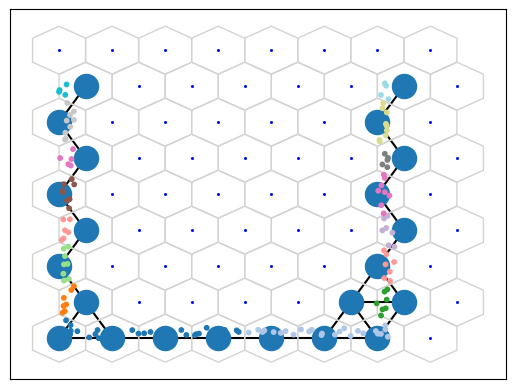

In [32]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

from track_linearization import plot_track_graph

fig, ax = plt.subplots()
ax.scatter(bin_centers[:, 0], bin_centers[:, 1], s=1, label="hexagonal grid")
patches = [
    mpatches.RegularPolygon(
        (x, y), numVertices=6, radius=hex_radius, orientation=hex_orientation
    )
    for x, y in bin_centers
]


collection = PatchCollection(
    patches, edgecolor="lightgrey", facecolor="none", linewidths=1
)
ax.add_collection(collection)
ax.plot(
    bin_centers[:, 0],
    bin_centers[:, 1],
    marker="o",
    markersize=1,
    color="blue",
    linestyle="None",
    label="midpoint",
)
plot_track_graph(connectivity_graph, ax=ax)
ax.scatter(
    position[:, 0],
    position[:, 1],
    zorder=10,
    s=10,
    label="observations",
    c=bin_ind,
    cmap="tab20",
)

In [ ]:
from typing import Protocol, runtime_checkable


@runtime_checkable
class Testable(Protocol):
    def __call__(self, *args, **kwargs) -> None:
        pass
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"

    def testing(self, *args, **kwargs) -> None:
        pass


class TestableClass:
    def __call__(self, *args, **kwargs) -> None:
        print("TestableClass called with args:", args, "and kwargs:", kwargs)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"

    def testing(self, *args, **kwargs) -> None:
        print("Testing method called with args:", args, "and kwargs:", kwargs)


isinstance(TestableClass(), Testable)

True